GAUSSIAN PROCESS REGRESSION - HAND CALCULATIONS IN CODE

1. MODEL SETUP
--------------------
Training points X: [0. 1. 2.]
Training values y: [0.5 1.2 0.8]
Test point x*: [1.5]

Hyperparameters:
  κ (magnitude): 1.0
  ℓ (lengthscale): 1.0
  σ (noise): 0.1

2. KERNEL FUNCTION
--------------------
Kernel: k(x,x') = κ² exp(-½||x-x'||²/ℓ²)

3. KERNEL MATRIX COMPUTATIONS
--------------------

3.1 Training covariance matrix K(X,X):
K[0,0] = k(0.0, 0.0) = 1.0000
K[0,1] = k(0.0, 1.0) = 0.6065
K[0,2] = k(0.0, 2.0) = 0.1353
K[1,0] = k(1.0, 0.0) = 0.6065
K[1,1] = k(1.0, 1.0) = 1.0000
K[1,2] = k(1.0, 2.0) = 0.6065
K[2,0] = k(2.0, 0.0) = 0.1353
K[2,1] = k(2.0, 1.0) = 0.6065
K[2,2] = k(2.0, 2.0) = 1.0000

K_XX =
[[1.         0.60653067 0.13533528]
 [0.60653067 1.         0.60653067]
 [0.13533528 0.60653067 1.        ]]

3.2 Add noise: C = K_XX + σ²I (σ² = 0.0100)
C =
[[1.01       0.60653067 0.13533528]
 [0.60653067 1.01       0.60653067]
 [0.13533528 0.60653067 1.01      ]]

3.3 Test-train covarianc

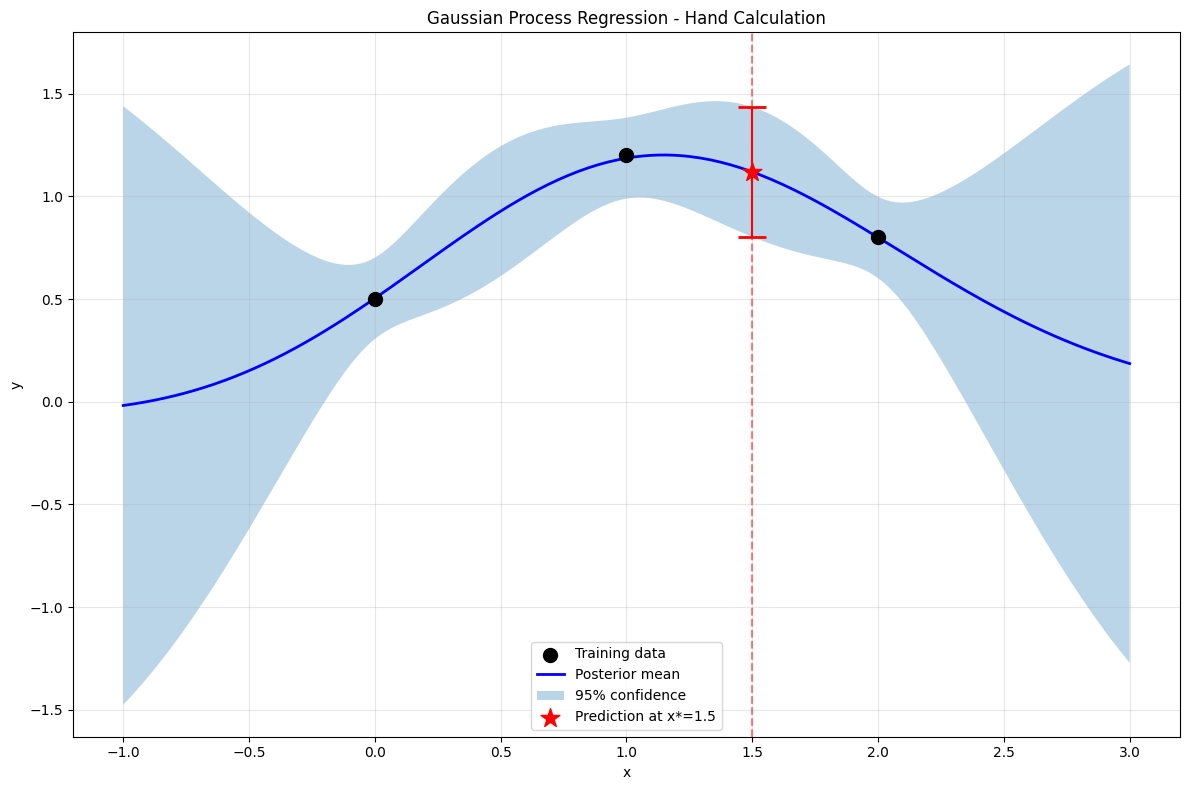


9. SUMMARY
--------------------

For test point x* = 1.5:
- Posterior mean: 1.1192
- Posterior std:  0.1582
- 95% CI: [0.8029, 1.4356]

Key insights:
1. Predictions interpolate smoothly between data points
2. Uncertainty is lowest near training data
3. Lengthscale ℓ controls smoothness
4. Noise σ controls observation uncertainty
5. Magnitude κ controls function variance

10. EFFECT OF HYPERPARAMETERS
--------------------


ValueError: 'x' has size 200, but 'y1' has an unequal size of 40000

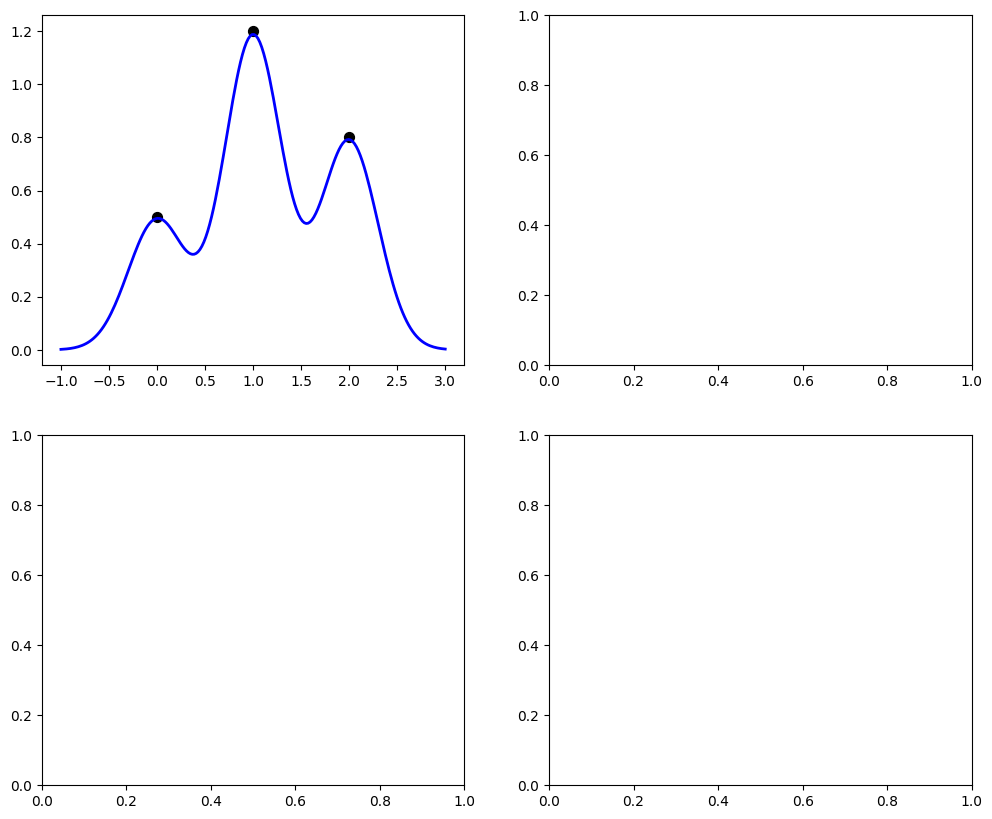

In [4]:
import numpy as np
import jax.numpy as jnp
from scipy.stats import norm
import matplotlib.pyplot as plt

print("=" * 60)
print("GAUSSIAN PROCESS REGRESSION - HAND CALCULATIONS IN CODE")
print("=" * 60)

# 1. Model Setup
print("\n1. MODEL SETUP")
print("-" * 20)

# Simple 1D example with 3 training points
X_train = jnp.array([[0.0], [1.0], [2.0]])  # Shape: (3, 1)
y_train = jnp.array([[0.5], [1.2], [0.8]])  # Shape: (3, 1)
x_test = jnp.array([[1.5]])  # Single test point

# Hyperparameters
kappa = 1.0      # Magnitude
ell = 1.0        # Lengthscale
sigma = 0.1      # Noise standard deviation

print(f"Training points X: {X_train.ravel()}")
print(f"Training values y: {y_train.ravel()}")
print(f"Test point x*: {x_test.ravel()}")
print(f"\nHyperparameters:")
print(f"  κ (magnitude): {kappa}")
print(f"  ℓ (lengthscale): {ell}")
print(f"  σ (noise): {sigma}")

# 2. Kernel Function Definition
print("\n2. KERNEL FUNCTION")
print("-" * 20)

def squared_exponential_kernel(x1, x2, kappa, ell):
    """
    Squared exponential (RBF) kernel
    k(x, x') = κ² exp(-½||x-x'||²/ℓ²)
    """
    dist_sq = jnp.sum((x1 - x2)**2)
    return kappa**2 * jnp.exp(-0.5 * dist_sq / ell**2)

print("Kernel: k(x,x') = κ² exp(-½||x-x'||²/ℓ²)")

# 3. Compute Kernel Matrices
print("\n3. KERNEL MATRIX COMPUTATIONS")
print("-" * 20)

# 3.1 Training covariance matrix K(X,X)
n_train = len(X_train)
K_XX = jnp.zeros((n_train, n_train))

print("\n3.1 Training covariance matrix K(X,X):")
for i in range(n_train):
    for j in range(n_train):
        K_XX = K_XX.at[i, j].set(
            squared_exponential_kernel(X_train[i], X_train[j], kappa, ell)
        )
        print(f"K[{i},{j}] = k({X_train[i,0]:.1f}, {X_train[j,0]:.1f}) = {K_XX[i,j]:.4f}")

print("\nK_XX =")
print(K_XX)

# 3.2 Add noise to diagonal
C = K_XX + sigma**2 * jnp.eye(n_train)
print(f"\n3.2 Add noise: C = K_XX + σ²I (σ² = {sigma**2:.4f})")
print("C =")
print(C)

# 3.3 Test-train covariance k(x*, X)
k_star = jnp.zeros((1, n_train))
print("\n3.3 Test-train covariance k(x*, X):")
for i in range(n_train):
    k_star = k_star.at[0, i].set(
        squared_exponential_kernel(x_test[0], X_train[i], kappa, ell)
    )
    print(f"k*[{i}] = k({x_test[0,0]:.1f}, {X_train[i,0]:.1f}) = {k_star[0,i]:.4f}")

print(f"\nk* = {k_star}")

# 3.4 Test-test covariance k(x*, x*)
k_star_star = squared_exponential_kernel(x_test[0], x_test[0], kappa, ell)
print(f"\n3.4 Test-test covariance: k** = k({x_test[0,0]:.1f}, {x_test[0,0]:.1f}) = {k_star_star:.4f}")

# 4. Posterior Mean Calculation
print("\n4. POSTERIOR MEAN CALCULATION")
print("-" * 20)

# 4.1 Solve C @ alpha = y
print("\n4.1 Solve C @ α = y for α:")
alpha = jnp.linalg.solve(C, y_train)
print(f"α = C⁻¹ @ y = {alpha.ravel()}")

# Verify solution
print(f"Verification: C @ α = {(C @ alpha).ravel()}")
print(f"Should equal y = {y_train.ravel()}")

# 4.2 Compute posterior mean
mu_star = k_star @ alpha
print(f"\n4.2 Posterior mean: μ* = k*ᵀ @ α")
print(f"μ* = {k_star} @ {alpha.ravel()}")
print(f"   = {mu_star[0,0]:.4f}")

# 5. Posterior Variance Calculation
print("\n5. POSTERIOR VARIANCE CALCULATION")
print("-" * 20)

# 5.1 Solve C @ v = k*ᵀ
print("\n5.1 Solve C @ v = k*ᵀ for v:")
v = jnp.linalg.solve(C, k_star.T)
print(f"v = C⁻¹ @ k*ᵀ = {v.ravel()}")

# 5.2 Compute posterior variance
var_star = k_star_star - k_star @ v
print(f"\n5.2 Posterior variance: σ²* = k** - k* @ v")
print(f"σ²* = {k_star_star:.4f} - {k_star} @ {v.ravel()}")
print(f"    = {k_star_star:.4f} - {(k_star @ v)[0,0]:.4f}")
print(f"    = {var_star[0,0]:.4f}")

# 5.3 Standard deviation
std_star = jnp.sqrt(var_star[0,0])
print(f"\n5.3 Standard deviation: σ* = √{var_star[0,0]:.4f} = {std_star:.4f}")

# 6. Predictive Distribution
print("\n6. PREDICTIVE DISTRIBUTION")
print("-" * 20)

print(f"\n6.1 Function prediction at x* = {x_test[0,0]:.1f}:")
print(f"p(f*|X,y) = N({mu_star[0,0]:.4f}, {var_star[0,0]:.4f})")

print(f"\n6.2 Observation prediction (with noise):")
var_y_star = var_star[0,0] + sigma**2
std_y_star = jnp.sqrt(var_y_star)
print(f"p(y*|X,y) = N({mu_star[0,0]:.4f}, {var_y_star:.4f})")

print(f"\n6.3 95% Confidence intervals:")
print(f"For f*: [{mu_star[0,0] - 2*std_star:.4f}, {mu_star[0,0] + 2*std_star:.4f}]")
print(f"For y*: [{mu_star[0,0] - 2*std_y_star:.4f}, {mu_star[0,0] + 2*std_y_star:.4f}]")

# 7. Marginal Likelihood
print("\n7. MARGINAL LIKELIHOOD")
print("-" * 20)

# 7.1 Cholesky decomposition
L = jnp.linalg.cholesky(C)
print("\n7.1 Cholesky decomposition: C = L @ Lᵀ")
print("L =")
print(L)

# 7.2 Solve L @ u = y
u = jnp.linalg.solve(L, y_train)
print(f"\n7.2 Solve L @ u = y:")
print(f"u = {u.ravel()}")

# 7.3 Compute log marginal likelihood components
data_fit = -0.5 * jnp.sum(u**2)
complexity = -jnp.sum(jnp.log(jnp.diag(L)))
normalization = -0.5 * n_train * jnp.log(2 * jnp.pi)

log_ml = data_fit + complexity + normalization

print(f"\n7.3 Log marginal likelihood components:")
print(f"Data fit term:      -½||u||² = {data_fit:.4f}")
print(f"Complexity term:    -log|L| = {complexity:.4f}")
print(f"Normalization:      -½n log(2π) = {normalization:.4f}")
print(f"\nTotal: log p(y|X,θ) = {log_ml:.4f}")

# 8. Visualization
print("\n8. VISUALIZATION")
print("-" * 20)

# Create dense test grid
x_plot = jnp.linspace(-1, 3, 200).reshape(-1, 1)
n_plot = len(x_plot)

# Compute posterior mean and variance for all test points
K_Xplot = jnp.zeros((n_train, n_plot))
for i in range(n_train):
    for j in range(n_plot):
        K_Xplot = K_Xplot.at[i, j].set(
            squared_exponential_kernel(X_train[i], x_plot[j], kappa, ell)
        )

# Posterior mean for all points
alpha_full = jnp.linalg.solve(C, y_train)
mu_plot = K_Xplot.T @ alpha_full

# Posterior variance for all points
K_plotplot = jnp.zeros((n_plot, n_plot))
for i in range(n_plot):
    K_plotplot = K_plotplot.at[i, i].set(
        squared_exponential_kernel(x_plot[i], x_plot[i], kappa, ell)
    )

V = jnp.linalg.solve(C, K_Xplot)
Sigma_plot = K_plotplot - K_Xplot.T @ V
var_plot = jnp.diag(Sigma_plot)
std_plot = jnp.sqrt(var_plot)

x   = jnp.array(x_plot).ravel()                     # shape (200,)
mu  = jnp.array(mu_plot).ravel()                    # shape (200,)
std = jnp.sqrt(jnp.diag(jnp.array(Sigma_plot)))     # shape (200,)

# Create plot
plt.figure(figsize=(12, 8))

# Plot training data
plt.scatter(X_train, y_train, c='black', s=100, zorder=5, label='Training data')

# Plot posterior mean
plt.plot(x_plot, mu_plot, 'b-', linewidth=2, label='Posterior mean')

# Plot confidence bands
plt.fill_between(x,
                 mu - 2*std,
                 mu + 2*std,
                 alpha=0.3, label='95% confidence')

# Highlight test point
plt.scatter(x_test, mu_star, c='red', s=200, marker='*', zorder=5,
           label=f'Prediction at x*={x_test[0,0]:.1f}')
plt.axvline(x_test[0,0], color='red', linestyle='--', alpha=0.5)

# Add error bars at test point
plt.errorbar(x_test[0,0], mu_star[0,0], yerr=2*std_star,
            color='red', capsize=10, capthick=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Process Regression - Hand Calculation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Summary
print("\n9. SUMMARY")
print("-" * 20)
print(f"\nFor test point x* = {x_test[0,0]:.1f}:")
print(f"- Posterior mean: {mu_star[0,0]:.4f}")
print(f"- Posterior std:  {std_star:.4f}")
print(f"- 95% CI: [{mu_star[0,0] - 2*std_star:.4f}, {mu_star[0,0] + 2*std_star:.4f}]")

print("\nKey insights:")
print("1. Predictions interpolate smoothly between data points")
print("2. Uncertainty is lowest near training data")
print("3. Lengthscale ℓ controls smoothness")
print("4. Noise σ controls observation uncertainty")
print("5. Magnitude κ controls function variance")

# 10. Effect of Hyperparameters
print("\n10. EFFECT OF HYPERPARAMETERS")
print("-" * 20)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Different hyperparameter settings
hyperparam_sets = [
    {'kappa': 1.0, 'ell': 0.3, 'sigma': 0.1, 'title': 'Short lengthscale (ℓ=0.3)'},
    {'kappa': 1.0, 'ell': 3.0, 'sigma': 0.1, 'title': 'Long lengthscale (ℓ=3.0)'},
    {'kappa': 0.3, 'ell': 1.0, 'sigma': 0.1, 'title': 'Small magnitude (κ=0.3)'},
    {'kappa': 1.0, 'ell': 1.0, 'sigma': 0.5, 'title': 'Large noise (σ=0.5)'},
]

for idx, params in enumerate(hyperparam_sets):
    ax = axes[idx // 2, idx % 2]
    
    # Recompute with new hyperparameters
    K_XX_new = jnp.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(n_train):
            K_XX_new = K_XX_new.at[i, j].set(
                squared_exponential_kernel(X_train[i], X_train[j], 
                                         params['kappa'], params['ell'])
            )
    
    C_new = K_XX_new + params['sigma']**2 * jnp.eye(n_train)
    
    K_Xplot_new = jnp.zeros((n_train, n_plot))
    for i in range(n_train):
        for j in range(n_plot):
            K_Xplot_new = K_Xplot_new.at[i, j].set(
                squared_exponential_kernel(X_train[i], x_plot[j], 
                                         params['kappa'], params['ell'])
            )
    
    alpha_new = jnp.linalg.solve(C_new, y_train)
    mu_plot_new = K_Xplot_new.T @ alpha_new
    
    V_new = jnp.linalg.solve(C_new, K_Xplot_new)
    var_plot_new = jnp.ones(n_plot) * params['kappa']**2 - jnp.sum(K_Xplot_new * V_new, axis=0)
    std_plot_new = jnp.sqrt(var_plot_new)
    
    # Plot
    ax.scatter(X_train, y_train, c='black', s=50)
    ax.plot(x_plot, mu_plot_new, 'b-', linewidth=2)
    ax.fill_between(x_plot.ravel(),
                   (mu_plot_new - 2*std_plot_new).ravel(),
                   (mu_plot_new + 2*std_plot_new).ravel(),
                   alpha=0.3, color='blue')
    ax.set_title(params['title'])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)

plt.suptitle('Effect of Hyperparameters on GP Predictions')
plt.tight_layout()
plt.show()

print("\nHyperparameter effects:")
print("- Short ℓ: More flexible, captures local variations")
print("- Long ℓ: Smoother, captures global trends")
print("- Small κ: Smaller function variations")
print("- Large σ: More uncertainty, less exact interpolation")